In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Duke/2022-2023/ECE 480/Project/Project Code')

Mounted at /content/drive


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
import csv
import re
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Functions and Classes

In [224]:
def load_dataset(path):
  with open(path) as csv_file:
    # read the data file, where MFCCs are delimited by spaces, all our data is numerical so we want it to convert to floats
    csv_reader = csv.reader(csv_file, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
    # initialize a list to hold the data, where data[k] is the kth block in the dataset
    data = []
    frame = 0
    block = 0
    for row in csv_reader:
      if row != ['']*13:
        # if we're on the first frame of a block, initialize the array to hold the block
        if frame == 0:
          utter = [row]
        # for all other frames, accumulate the frames of the block into one array
        else:
          utter.extend([row])
        frame += 1
      # if we have a blank line, we're between blocks
      if row == ['']*13:
        # store the current block as an array in the list
        data.extend(np.array([utter]))
        # iterate to the next block
        block += 1
        # reset the frame counter
        frame = 0
    # after iterating to the end of the file, we don't have an empty line, so add the current block to the dictionary
    data.extend(np.array([utter]))

    return data

In [225]:
# plots the MFCCs for 4 random blocks/utterances for the input digit
# defaults to plotting all 13 MFCCs, but can pass a list of which ones to include
def plot_MFCCs(digit, phonemes, mfccs_list=np.arange(1,14), legend=True):
  # creates a list of 13 colors and five shapes from matplotlib 
  colors_list = list(mcolors.TABLEAU_COLORS.values())
  colors_list.extend(['k', 'm', 'r'])
  marker_list = ['o', '^', 's', '*', 'P']
  

  # slice out the given digit's data from the training data
  data = train_data_all[digit*660:digit*660+660]
  np.random.seed(1)
  samples = np.random.choice(data, 4, replace=False)
  k = 0
  fig, axs = plt.subplots(2, 4, sharex='col', sharey='row')
  fig.set_size_inches(12, 7)
  fig.suptitle('Unclustered and Clustered MFCC Values For Spoken Digit {}, 4 Samples'.format(digit))
  axs[0][0].set_ylabel('MFCC Value')
  axs[1][0].set_ylabel('MFCC Value')
  # choose 4 random blocks from the digit's data
  for utterance in samples:
    labels_list = []
    frame_window = np.arange(utterance[:,0].size)
    # plot the values for each of the selected MFCCs
    for mfcc in mfccs_list:
      # choose the color based on the MFCC being plotted
      axs[0][k].plot(frame_window, utterance[:, mfcc-1], color=colors_list[mfcc-1])
      labels_list.append('MFCC{}'.format(mfcc))
      # can choose whether or not to include the legend for readability
    if legend:
      axs[0][k].legend(labels=labels_list, loc='lower right')
    # cluster the samples and plot them with cluster ID encoded
    kmeans = KMeans(n_clusters=phonemes).fit(utterance)
    labels_list = []
    for mfcc in mfccs_list:
      for j in range(phonemes):
        axs[1][k].plot(frame_window[kmeans.labels_==j], utterance[:, mfcc-1][kmeans.labels_==j], '{}'.format(marker_list[j]), color = colors_list[mfcc-1])
        axs[1][k].set_xlabel('Frame Index')
        if mfcc == mfccs_list[0]:
          labels_list.append('Cluster ID {}'.format(j))
    if legend:
      handle_list = []
      for j in range(phonemes):
        line = mlines.Line2D([], [], color='black', linestyle='None', marker=marker_list[j], label='Cluster ID {}'.format(j))
        handle_list.append(line)
      axs[1][k].legend(handles=handle_list, loc='lower right')
      
    k+=1

In [226]:
def scatter_MFCCs(digit, mfccs_arr, phonemes):
  colors_list = ['r', 'g', 'b', 'c', 'm', 'y', 'k']
  marker_list = ['o', '^', 's', '*', 'P']

  # slice out the given digit's data from the training data
  data = train_data_all[digit*660:digit*660+660]
  np.random.seed(1)
  # pick a couple samples
  samples = np.random.choice(data, 4, replace=False)
  samples = np.concatenate(samples)[:, tuple(mfccs_arr-1)]
  # cluster the samples and plot the MFCCs pairwise with the clustering encoded
  kmeans = KMeans(n_clusters=phonemes).fit(samples)

  fig, axs = plt.subplots(1, 2, sharey='row')
  fig.set_size_inches(7,4)
  axs[0].set_ylabel('MFCC{}'.format(mfccs_arr[1]))
  axs[0].scatter(samples[:,0], samples[:,1])
  for k in range(phonemes):
    axs[1].scatter(samples[:,0][kmeans.labels_==k], samples[:,1][kmeans.labels_==k], color=colors_list[k], marker=marker_list[k], label='Cluster ID {}'.format(k))
  axs[0].set_xlabel('MFCC{}'.format(mfccs_arr[0]))
  axs[1].set_xlabel('MFCC{}'.format(mfccs_arr[0]))
  plt.suptitle('Unclustered and Clustered Pairwise Plots of MFCCs From 4 Samples for Spoken Digit {}'.format(digit))
  axs[1].legend()




In [227]:
# calculate the likelihoods for each of a block's samples given a mixture component's parameters
def calc_L(block, mean, cov, mfccs):
  # dimension of the mixture component = # of mfccs used
  D = mfccs.size
  # create an empty array to hold the likelihood for each sample in the block
  num_samples = block[:,0].size
  scores = np.empty((num_samples, 1))

  # iterate through each row (sample) in the block
  for k in range(num_samples):
    # formula for pdf of a multivariate normal distribution given its mean and covariance
    const = (1 / (((2*np.pi)**(D/2)) * np.linalg.det(cov)**(1/2)))
    right = np.exp((-1/2) * (block[k] - mean) @ np.linalg.inv(cov) @ (block[k] - mean).T)
    prob = const * right
    scores[k] = prob
  # return an array of the log likelihoods for each frame in the input block
  return scores  


In [228]:
# class that sets up all the properties for the GMM for a given digit
class DigitModel:
  def __init__(self, digit, phonemes, EM, cov_type, mfccs_list=np.arange(1,14)):
    # slice out the data for the given digit and concatenate it together
    data = train_data_all[digit*660:digit*660+660]
    # only include the MFCCs we want to use for the model
    data = np.concatenate(data)[:, tuple(mfccs_list-1)]
    # store the data for the digit, the number of components, the covariance type to use, and the MFCCs to use for training
    self.data = data
    self.phonemes = phonemes
    self.cov_type = cov_type
    self.mfccs = mfccs_list
    
    # we're building a GMM using EM
    if EM:
      # fit the GMM using EM to find GMM parameters
      # use number of components equal to number of phonemes
      self.EM = GaussianMixture(n_components=phonemes, covariance_type=cov_type).fit(data)
      # save the component weights, means, and covariances directly from the sklearn class
      self.covs = self.EM.covariances_
      # the sklearn package only reports the diagonals of the covariances for 'diag', convert them here to matrices
      if cov_type == 'diag':
        covs = []
        for k in range(phonemes):
          covs.append(np.diag(self.covs[k]))
        self.covs = covs
      self.means = self.EM.means_
      self.weights = self.EM.weights_
    
    # we're not using EM, and therefore using K-Means
    else:
      # perform k-means clustering, then find the GMM parameters
      # use number of clusters equal to number of phonemes
      self.kmeans = KMeans(n_clusters=phonemes).fit(data)
      #TODO
      means = []
      covs = []
      weights = []
      
      # find weights, means, and covariances (based on cov_type) from clusters 
      for k in range(phonemes):
        # slice out the data corresponding to the current cluster
        cluster_data = self.data[self.kmeans.labels_==k]
        # mean vector is the mean along the rows
        means.append(np.mean(cluster_data, axis=0))
        # weight for this component is the number of frames in the cluster over the total number of frames for the digit
        weights.append(cluster_data[:,0].size / self.data[:,0].size)

        if self.cov_type == 'full':
          # find the covariance for all the data in the cluster
          cov = np.cov(cluster_data, rowvar=False)
          covs.append(cov)
        if self.cov_type == 'diag':
          # find the variance for each variable to find the diagonals
          diags = np.var(cluster_data, axis=0)
          cov = np.diag(diags)
          covs.append(cov)

      self.means = means
      self.covs = covs
      # compute tied cov outside of loop by pooling data
      if self.cov_type =='tied':
        pooled_data = self.data - np.mean(self.data, axis=0)
        cov = np.cov(pooled_data, rowvar=False)
        self.covs = cov
      self.weights = weights



  def eval_model(self, test_data):
    # create an empty array to hold the likelihoods for each utterance in the test set
    all_scores = np.empty((len(test_data), 1))

    for block_idx, block in enumerate(test_data):
      # we're examining one block (utterance) from the test set
      # slice out only the MFCCs in the block that were also used to train the model
      block = block[:, tuple(self.mfccs-1)]
      num_frames = block[:,0].size
      # zero array to hold the likelihood of the sample in each analysis frame
      probs = np.zeros((num_frames, 1))

      for k in range(self.phonemes):
        # iterating through the number of mixture components in the GMM, select the mean, covariance, and weight from the kth component
        mean = self.means[k]
        if self.cov_type == 'tied':
          # if we have a tied covariance, use the one covariance in self.covs every time
          cov = self.covs
        else:
          cov = self.covs[k]
        weight = self.weights[k]
        # sum the likelihood corresponding to the kth mixture component
        probs += weight * calc_L(block, mean, cov, self.mfccs)
      
      # the likelihood for the whole block is equal to the product of the likelihoods
      # using log product rule, this is equal to the sum of the log of each likelihood 
      # normalize by the number of frames in order to avoid bias due to "longer" utterances
      all_scores[block_idx] = np.sum(np.log(probs)) / num_frames

    # return all the likelihoods for each block for this digit model, which is a 2200x1 array
    return all_scores
    


In [229]:
# evaluate the models on the test set and return their predictions
def test_models(model_list, test_data):
  # empty array to hold scores for all test utterances for all models
  model_scores = np.empty((len(test_data), 10))

  for digit, model in enumerate(model_list):
    # for each of the 10 digit models, fill the corresponding column of the scores array with the likelihoods from that model
    model_scores[:, [digit]] = model.eval_model(test_data)

  # predicted contains the index where the max likelihood occurs for each utterance, can match these labels with the test_labels created earlier
  predicted = np.argmax(model_scores, axis=1)
  return model_scores, predicted

In [230]:
# return performance metrics given the predictions for all models and the ground truth labels of the test set
def model_metrics(predicted, labels, title):
  # count the number of times the prediction matched the label
  correct = np.sum(predicted==labels)
  # probability of choosing the correct digit is the total number of times a correct prediction was made divided by the amount of utterances in the test set
  prob_correct_digit = correct / predicted.size
  
  # compute the confusion matrix, where for each entry at index i, j is the probability that we predicted j when the ground truth was i
  confuse = confusion_matrix(labels, predicted, labels=np.arange(0,10), normalize='true')
  # create a display for the confusion matrix, set figure size, title, and labels
  confuse_disp = ConfusionMatrixDisplay(confuse)
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_title(title)
  ax.set_xlabel('Predicted Digit')
  ax.set_ylabel('True Digit')
  # return the probability of a correct digit and display the confusion matrix
  confuse_disp.plot(ax=ax)
  return prob_correct_digit

# Testing Code

In [10]:
# load the training and test data
train_data_all = load_dataset('/content/drive/MyDrive/Duke/2022-2023/ECE 480/Project/Project Code/Train_Arabic_Digit.txt')
test_data_all = load_dataset('/content/drive/MyDrive/Duke/2022-2023/ECE 480/Project/Project Code/Test_Arabic_Digit.txt')
# construct the array of labels for the test data
test_labels = np.zeros(220)
for k in range(1, 10):
  test_labels = np.append(test_labels, k*np.ones(220))

In [11]:
# assures that the data was loaded and split correctly
# sizes should be 6600, 2200, 2200
print(len(train_data_all))
print(len(test_data_all))
print(test_labels.size)

6600
2200
2200


In [ ]:
# plot some examples of the MFCC values as a function of window index 
# useful to visualize the phoneme transitions and determine how many components to use
plot_MFCCs(digit=2, phonemes=3, mfccs_list=np.arange(1,4), legend=True)

In [ ]:
# plot the pairwise MFCCs for those same samples
scatter_MFCCs(digit=2, mfccs_arr=np.array([1,2]), phonemes=3)

In [253]:
# build all the models that are needed
model_list = []
# choose if model is EM or k-means
EM = False
# manually input the amount of phonemes to use for digits 0-9 here
phoneme_list = [3, 3, 3, 3, 4, 3, 3, 3, 4, 3]
# input the array of mfccs to use
mfcc_list = np.arange(1, 8)
# choose the covariance type
# 'full': individual full covariances
# 'tied': tied full covariance
# 'diag': individual diagonal covariances
cov_type = 'full'

# build the model for each digit and add it to the list
for k in range(10):
  model_list.append(DigitModel(digit=k, phonemes=phoneme_list[k], EM=EM, cov_type=cov_type, mfccs_list=mfcc_list))

In [ ]:
digit = 9
# look at the results for a single digit in the test set
scores, predicted = test_models(model_list, test_data_all[digit*220:digit*220+220])
prob_correct = model_metrics(predicted, test_labels[digit*220:digit*220+220], 'Confusion Matrix for EM Models Evaluated On Test Data')

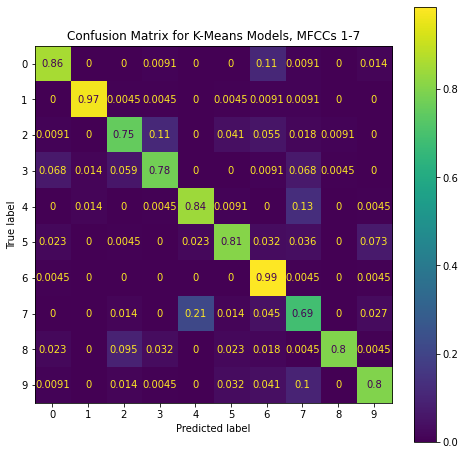

In [254]:
# report the probability of choosing a correct digit (accuracy of the classifier) and the confusion matrix for the entire test set
scores, predicted = test_models(model_list, test_data_all)
prob_correct = model_metrics(predicted, test_labels, 'Confusion Matrix for K-Means Models, MFCCs 1-7')

In [255]:
print('{:.4}'.format(prob_correct))

0.8282
